# Intro

* Freezing a layer means to switch off gradient descent in that layer
* This means that the weights will not change , and thus the layer will no longer learn
* requires_grad is a toggle that switches on (True) or off (False) learning in for that weight matrix (or bias)

Why to switch off learning?

* The main application is when working with downloaded (pretrained) networks.
* The network is already trained, but you need to fine-tune it for you specific dataset

# Data

In [39]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import time

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipython-input-2368014486.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [40]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

labels = data[:,0]
data = data[:,1:]

labels = torch.tensor(labels, dtype = torch.long)
data = torch.tensor(data, dtype = torch.float)

# normalization
data_norm = data / torch.max(data)

labels, data_norm

(tensor([6, 5, 7,  ..., 2, 9, 5]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

# Split

In [41]:
train_data, test_data, train_labels, test_labels = train_test_split(data_norm, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

# Model

In [42]:
def CreateNet():

  class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784, 128)

      self.fc1 = nn.Linear(128,64)
      self.fc2 = nn.Linear(64,64)

      self.output = nn.Linear(64,10)

    def forward(self, x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.output(x)
      return torch.log_softmax(x, axis = 1)

  net = Net()
  loss_fn = nn.NLLLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
  return net, loss_fn, optimizer

CreateNet()

(Net(
   (input): Linear(in_features=784, out_features=128, bias=True)
   (fc1): Linear(in_features=128, out_features=64, bias=True)
   (fc2): Linear(in_features=64, out_features=64, bias=True)
   (output): Linear(in_features=64, out_features=10, bias=True)
 ),
 NLLLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

# OFF all layers but input

## requires_grad

In [43]:
net = CreateNet()[0]
net.fc1.weight.requires_grad

True

In [44]:
for name, param in net.named_parameters():
  if 'input' not in name:
    param.requires_grad = False

# check
for p in net.named_parameters():
  print('Requires_grad status in layer %s: %s' %(p[0], p[1].requires_grad))

Requires_grad status in layer input.weight: True
Requires_grad status in layer input.bias: True
Requires_grad status in layer fc1.weight: False
Requires_grad status in layer fc1.bias: False
Requires_grad status in layer fc2.weight: False
Requires_grad status in layer fc2.bias: False
Requires_grad status in layer output.weight: False
Requires_grad status in layer output.bias: False


## Train

In [45]:
def ModelTrain(epochs, verbose):
  net, loss_fn, optimizer = CreateNet()

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []


  for epoch in range(epochs):

    #### SWITCH OFF LEARNING IN ALL_BUT_OUTPUT LAYERS DURING FIRST 1/2 OF TRAINING
    if epoch < (epochs / 2):
      for p in net.named_parameters():
        if 'output' not in p[0]:
          p[1].requires_grad = False
    else:
      for p in net.named_parameters():
        p[1].requires_grad = True
    ##############################################################################

    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, losses

In [46]:
train_acc, test_acc, losses = ModelTrain(200, verbose = True)

Epoch: 0 | Train Acc: 11.43 | Test Acc: 11.55 | Loss: 2.30
Epoch: 10 | Train Acc: 12.06 | Test Acc: 12.22 | Loss: 2.29
Epoch: 20 | Train Acc: 14.79 | Test Acc: 13.90 | Loss: 2.29
Epoch: 30 | Train Acc: 16.06 | Test Acc: 16.52 | Loss: 2.28
Epoch: 40 | Train Acc: 17.98 | Test Acc: 17.33 | Loss: 2.28
Epoch: 50 | Train Acc: 18.70 | Test Acc: 17.95 | Loss: 2.27
Epoch: 60 | Train Acc: 19.57 | Test Acc: 18.73 | Loss: 2.26
Epoch: 70 | Train Acc: 20.33 | Test Acc: 20.00 | Loss: 2.26
Epoch: 80 | Train Acc: 21.76 | Test Acc: 21.42 | Loss: 2.25
Epoch: 90 | Train Acc: 23.77 | Test Acc: 22.75 | Loss: 2.25
Epoch: 100 | Train Acc: 46.92 | Test Acc: 53.40 | Loss: 1.90
Epoch: 110 | Train Acc: 90.41 | Test Acc: 90.22 | Loss: 0.34
Epoch: 120 | Train Acc: 93.42 | Test Acc: 92.80 | Loss: 0.23
Epoch: 130 | Train Acc: 95.36 | Test Acc: 94.07 | Loss: 0.17
Epoch: 140 | Train Acc: 96.62 | Test Acc: 94.62 | Loss: 0.12
Epoch: 150 | Train Acc: 97.54 | Test Acc: 95.28 | Loss: 0.09
Epoch: 160 | Train Acc: 98.27 | Tes

## Plot

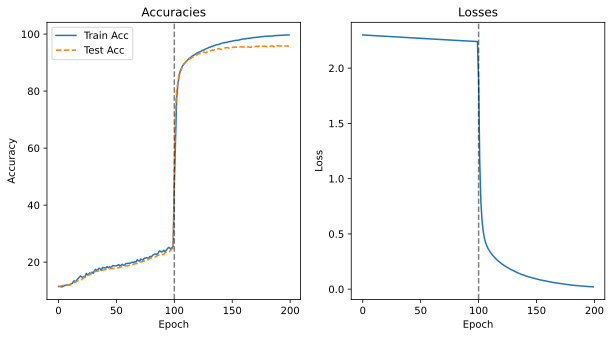

In [47]:
fig, ax = plt.subplots(1,2,figsize = (10,5))

ax[0].plot(train_acc)
ax[0].plot(test_acc, '--')
ax[0].set_title('Accuracies')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train Acc', 'Test Acc'])

ax[1].plot(losses)
ax[1].set_title('Losses')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

ax[0].axvline(x = 100, color = 'k', ls = '--', alpha=.5)
ax[1].axvline(x = 100, color = 'k', ls = '--', alpha = .5)

plt.show()

# OFF all weights, ON all biases

## requires_grad

In [48]:
net = CreateNet()[0]
net.fc1.weight.requires_grad

True

In [49]:
for name, param in net.named_parameters():
  if 'bias' not in name:
    param.requires_grad = False

# check
for p in net.named_parameters():
  print('Requires_grad status in layer %s: %s' %(p[0], p[1].requires_grad))

Requires_grad status in layer input.weight: False
Requires_grad status in layer input.bias: True
Requires_grad status in layer fc1.weight: False
Requires_grad status in layer fc1.bias: True
Requires_grad status in layer fc2.weight: False
Requires_grad status in layer fc2.bias: True
Requires_grad status in layer output.weight: False
Requires_grad status in layer output.bias: True


## Train

In [50]:
def ModelTrain(epochs, verbose):
  net, loss_fn, optimizer = CreateNet()

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []


  for epoch in range(epochs):

    if epoch < (epochs / 2):
      for name, param in net.named_parameters():
        if 'bias' not in name:
          param.requires_grad = False
    else:
      for name, param in net.named_parameters():
        param.requires_grad = True
    ##############################################################################

    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, losses

In [51]:
train_acc, test_acc, losses = ModelTrain(200, verbose = True)

Epoch: 0 | Train Acc: 10.77 | Test Acc: 10.05 | Loss: 2.30
Epoch: 10 | Train Acc: 11.21 | Test Acc: 11.28 | Loss: 2.30
Epoch: 20 | Train Acc: 11.20 | Test Acc: 11.28 | Loss: 2.29
Epoch: 30 | Train Acc: 11.31 | Test Acc: 11.30 | Loss: 2.29
Epoch: 40 | Train Acc: 11.27 | Test Acc: 11.42 | Loss: 2.29
Epoch: 50 | Train Acc: 11.47 | Test Acc: 11.45 | Loss: 2.29
Epoch: 60 | Train Acc: 12.17 | Test Acc: 11.52 | Loss: 2.29
Epoch: 70 | Train Acc: 11.34 | Test Acc: 11.77 | Loss: 2.29
Epoch: 80 | Train Acc: 11.57 | Test Acc: 11.55 | Loss: 2.29
Epoch: 90 | Train Acc: 11.59 | Test Acc: 11.68 | Loss: 2.29
Epoch: 100 | Train Acc: 18.91 | Test Acc: 30.45 | Loss: 2.27
Epoch: 110 | Train Acc: 88.08 | Test Acc: 88.00 | Loss: 0.41
Epoch: 120 | Train Acc: 91.92 | Test Acc: 91.45 | Loss: 0.28
Epoch: 130 | Train Acc: 94.14 | Test Acc: 93.28 | Loss: 0.20
Epoch: 140 | Train Acc: 95.64 | Test Acc: 94.47 | Loss: 0.15
Epoch: 150 | Train Acc: 97.01 | Test Acc: 95.03 | Loss: 0.11
Epoch: 160 | Train Acc: 97.73 | Tes

## Plot

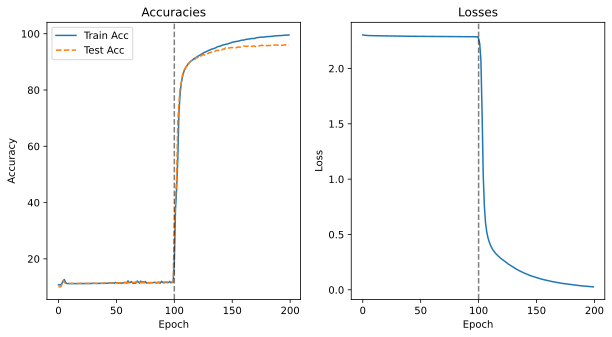

In [52]:
fig, ax = plt.subplots(1,2,figsize = (10,5))

ax[0].plot(train_acc)
ax[0].plot(test_acc, '--')
ax[0].set_title('Accuracies')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train Acc', 'Test Acc'])

ax[1].plot(losses)
ax[1].set_title('Losses')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

ax[0].axvline(x = 100, color = 'k', ls = '--', alpha=.5)
ax[1].axvline(x = 100, color = 'k', ls = '--', alpha=.5)

plt.show()

# ON all weights, OFF all biases

## requires_grad

In [53]:
net = CreateNet()[0]
net.fc1.weight.requires_grad

True

In [54]:
for name, param in net.named_parameters():
  if 'weight' not in name:
    param.requires_grad = False

# check
for p in net.named_parameters():
  print('Requires_grad status in layer %s: %s' %(p[0], p[1].requires_grad))

Requires_grad status in layer input.weight: True
Requires_grad status in layer input.bias: False
Requires_grad status in layer fc1.weight: True
Requires_grad status in layer fc1.bias: False
Requires_grad status in layer fc2.weight: True
Requires_grad status in layer fc2.bias: False
Requires_grad status in layer output.weight: True
Requires_grad status in layer output.bias: False


## Train

In [55]:
def ModelTrain(epochs, verbose):
  net, loss_fn, optimizer = CreateNet()

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []


  for epoch in range(epochs):

    if epoch < (epochs / 2):
      for name, param in net.named_parameters():
        if 'weight' not in name:
          param.requires_grad = False
    else:
      for name, param in net.named_parameters():
        param.requires_grad = True
    ##############################################################################

    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, losses

In [56]:
train_acc, test_acc, losses = ModelTrain(200, verbose = True)

Epoch: 0 | Train Acc: 12.08 | Test Acc: 18.67 | Loss: 2.30
Epoch: 10 | Train Acc: 86.29 | Test Acc: 86.18 | Loss: 0.48
Epoch: 20 | Train Acc: 91.50 | Test Acc: 91.00 | Loss: 0.29
Epoch: 30 | Train Acc: 93.78 | Test Acc: 92.65 | Loss: 0.22
Epoch: 40 | Train Acc: 95.41 | Test Acc: 94.20 | Loss: 0.16
Epoch: 50 | Train Acc: 96.75 | Test Acc: 95.00 | Loss: 0.12
Epoch: 60 | Train Acc: 97.69 | Test Acc: 95.45 | Loss: 0.09
Epoch: 70 | Train Acc: 98.24 | Test Acc: 95.50 | Loss: 0.07
Epoch: 80 | Train Acc: 98.82 | Test Acc: 95.70 | Loss: 0.05
Epoch: 90 | Train Acc: 99.18 | Test Acc: 95.72 | Loss: 0.04
Epoch: 100 | Train Acc: 99.47 | Test Acc: 95.90 | Loss: 0.03
Epoch: 110 | Train Acc: 99.71 | Test Acc: 95.85 | Loss: 0.02
Epoch: 120 | Train Acc: 99.83 | Test Acc: 95.92 | Loss: 0.02
Epoch: 130 | Train Acc: 99.89 | Test Acc: 96.00 | Loss: 0.01
Epoch: 140 | Train Acc: 99.93 | Test Acc: 96.05 | Loss: 0.01
Epoch: 150 | Train Acc: 99.95 | Test Acc: 95.97 | Loss: 0.01
Epoch: 160 | Train Acc: 99.97 | Tes

## Plot

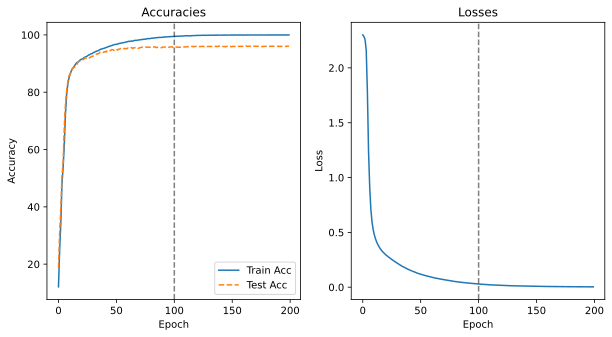

In [57]:
fig, ax = plt.subplots(1,2,figsize = (10,5))

ax[0].plot(train_acc)
ax[0].plot(test_acc, '--')
ax[0].set_title('Accuracies')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train Acc', 'Test Acc'])

ax[1].plot(losses)
ax[1].set_title('Losses')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

ax[0].axvline(x = 100, color = 'k', ls = '--', alpha=.5)
ax[1].axvline(x = 100, color = 'k', ls = '--', alpha=.5)

plt.show()

# OFF all weights, OFF all biases on fc1 only

## requires_grad

In [61]:
net = CreateNet()[0]
net.fc1.weight.requires_grad

True

In [62]:
for name, param in net.named_parameters():
  if 'fc1' in name:
    param.requires_grad = False

# check
for p in net.named_parameters():
  print('Requires_grad status in layer %s: %s' %(p[0], p[1].requires_grad))

Requires_grad status in layer input.weight: True
Requires_grad status in layer input.bias: True
Requires_grad status in layer fc1.weight: False
Requires_grad status in layer fc1.bias: False
Requires_grad status in layer fc2.weight: True
Requires_grad status in layer fc2.bias: True
Requires_grad status in layer output.weight: True
Requires_grad status in layer output.bias: True


## Train

In [63]:
def ModelTrain(epochs, verbose):
  net, loss_fn, optimizer = CreateNet()

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []


  for epoch in range(epochs):

    if epoch < (epochs / 2):
      for name, param in net.named_parameters():
        if 'fc1' in name:
          param.requires_grad = False
    else:
      for name, param in net.named_parameters():
        param.requires_grad = True
    ##############################################################################

    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, losses

In [65]:
train_acc, test_acc, losses = ModelTrain(200, verbose = True)

Epoch: 0 | Train Acc: 13.20 | Test Acc: 15.67 | Loss: 2.30
Epoch: 10 | Train Acc: 83.44 | Test Acc: 84.32 | Loss: 0.58
Epoch: 20 | Train Acc: 90.26 | Test Acc: 89.92 | Loss: 0.34
Epoch: 30 | Train Acc: 92.16 | Test Acc: 91.40 | Loss: 0.27
Epoch: 40 | Train Acc: 93.53 | Test Acc: 92.58 | Loss: 0.22
Epoch: 50 | Train Acc: 94.59 | Test Acc: 93.45 | Loss: 0.19
Epoch: 60 | Train Acc: 95.43 | Test Acc: 93.82 | Loss: 0.16
Epoch: 70 | Train Acc: 96.24 | Test Acc: 94.38 | Loss: 0.14
Epoch: 80 | Train Acc: 96.80 | Test Acc: 94.52 | Loss: 0.12
Epoch: 90 | Train Acc: 97.19 | Test Acc: 94.92 | Loss: 0.10
Epoch: 100 | Train Acc: 96.39 | Test Acc: 95.00 | Loss: 0.12
Epoch: 110 | Train Acc: 98.15 | Test Acc: 95.82 | Loss: 0.07
Epoch: 120 | Train Acc: 98.75 | Test Acc: 96.00 | Loss: 0.05
Epoch: 130 | Train Acc: 99.24 | Test Acc: 95.65 | Loss: 0.03
Epoch: 140 | Train Acc: 99.51 | Test Acc: 96.10 | Loss: 0.02
Epoch: 150 | Train Acc: 99.72 | Test Acc: 96.15 | Loss: 0.02
Epoch: 160 | Train Acc: 99.87 | Tes

## Plot

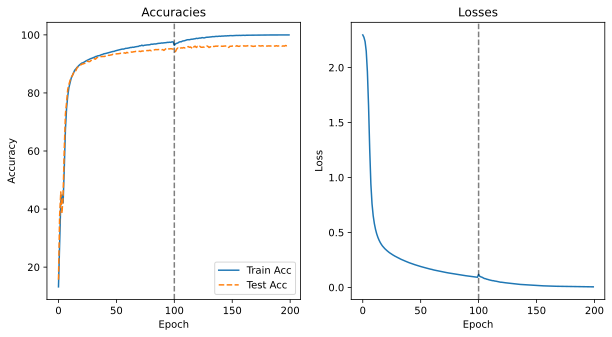

In [66]:
fig, ax = plt.subplots(1,2,figsize = (10,5))

ax[0].plot(train_acc)
ax[0].plot(test_acc, '--')
ax[0].set_title('Accuracies')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train Acc', 'Test Acc'])

ax[1].plot(losses)
ax[1].set_title('Losses')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

ax[0].axvline(x = 100, color = 'k', ls = '--', alpha=.5)
ax[1].axvline(x = 100, color = 'k', ls = '--', alpha=.5)

plt.show()